# Two-qubit States Reconstruction

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return pnt

In [6]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis
        #ax.plot(y, -x, z, marker='.', c='b', alpha=0.7)

In [7]:
#Choice of simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [8]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [9]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [10]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   return fidelity 

In [11]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [12]:
A = tf.stack([X_tf,Y_tf,Z_tf])

In [13]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   return infidelity 

In [14]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   return infidelity 

## Noise Model

In [15]:
#num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING CHANNELS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI CHANNEL
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS CHANNEL
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
#dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [16]:
#applies NOISE whenever an identity gate appears in the circuit (compatibly with the channels parameters)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

##  <font color='green'>Training the Algorithm (MSE)</font>

### <font color='green'>Different Channels on both Qubits</font>

In [101]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [102]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [103]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [104]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [105]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [106]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [107]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 1s 82ms/step - loss: 0.2041 - val_loss: 0.1934
Epoch 2/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1880 - val_loss: 0.1817
Epoch 3/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1747 - val_loss: 0.1712
Epoch 4/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1626 - val_loss: 0.1607
Epoch 5/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1506 - val_loss: 0.1498
Epoch 6/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1382 - val_loss: 0.1382
Epoch 7/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1258 - val_loss: 0.1262
Epoch 8/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1132 - val_loss: 0.1142
Epoch 9/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1007 - val_loss: 0.1026
Epoch 10/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0886 - val_loss: 0.0914
Epoch 11/

6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 84/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 85/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 86/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 87/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 88/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 89/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 90/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 91/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 92/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 93/1000


6/6 [==============================] - 0s 13ms/step - loss: 5.4271e-04 - val_loss: 0.0016
Epoch 163/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.4729e-04 - val_loss: 0.0016
Epoch 164/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.3819e-04 - val_loss: 0.0016
Epoch 165/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.3199e-04 - val_loss: 0.0016
Epoch 166/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.2413e-04 - val_loss: 0.0016
Epoch 167/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.1737e-04 - val_loss: 0.0016
Epoch 168/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.2445e-04 - val_loss: 0.0016
Epoch 169/1000
6/6 [==============================] - 0s 13ms/step - loss: 5.1891e-04 - val_loss: 0.0016
Epoch 170/1000
6/6 [==============================] - 0s 13ms/step - loss: 5.1487e-04 - val_loss: 0.0016
Epoch 171/1000
6/6 [==============================] - 0s 13ms/step - l

6/6 [==============================] - 0s 13ms/step - loss: 3.2700e-04 - val_loss: 0.0012
Epoch 241/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.2552e-04 - val_loss: 0.0012
Epoch 242/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.2236e-04 - val_loss: 0.0011
Epoch 243/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.2257e-04 - val_loss: 0.0011
Epoch 244/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.2389e-04 - val_loss: 0.0011
Epoch 245/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.2183e-04 - val_loss: 0.0012
Epoch 246/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.2637e-04 - val_loss: 0.0011
Epoch 247/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.2714e-04 - val_loss: 0.0011
Epoch 248/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.2713e-04 - val_loss: 0.0011
Epoch 249/1000
6/6 [==============================] - 0s 12ms/step - l

Epoch 317/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.4214e-04 - val_loss: 9.1495e-04
Epoch 318/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.3808e-04 - val_loss: 9.0587e-04
Epoch 319/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.3958e-04 - val_loss: 9.1199e-04
Epoch 320/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4119e-04 - val_loss: 9.3061e-04
Epoch 321/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4992e-04 - val_loss: 9.2419e-04
Epoch 322/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4578e-04 - val_loss: 8.9981e-04
Epoch 323/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.3625e-04 - val_loss: 8.9840e-04
Epoch 324/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.2806e-04 - val_loss: 9.0205e-04
Epoch 325/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.3060e-04 - val_loss: 9.0416e-04
Epoch 326/1000
6/6 

6/6 [==============================] - 0s 12ms/step - loss: 1.7848e-04 - val_loss: 7.4099e-04
Epoch 393/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.7270e-04 - val_loss: 7.4047e-04
Epoch 394/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.7062e-04 - val_loss: 7.4474e-04
Epoch 395/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.7367e-04 - val_loss: 7.3683e-04
Epoch 396/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.6867e-04 - val_loss: 7.2866e-04
Epoch 397/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.7396e-04 - val_loss: 7.3405e-04
Epoch 398/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.7116e-04 - val_loss: 7.2546e-04
Epoch 399/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.6620e-04 - val_loss: 7.3129e-04
Epoch 400/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.6692e-04 - val_loss: 7.3660e-04
Epoch 401/1000
6/6 [==============

6/6 [==============================] - 0s 13ms/step - loss: 1.3128e-04 - val_loss: 6.1640e-04
Epoch 468/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.3162e-04 - val_loss: 6.2180e-04
Epoch 469/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2950e-04 - val_loss: 6.1366e-04
Epoch 470/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.2556e-04 - val_loss: 6.1570e-04
Epoch 471/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2803e-04 - val_loss: 6.1083e-04
Epoch 472/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.3089e-04 - val_loss: 6.1151e-04
Epoch 473/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.3663e-04 - val_loss: 6.1559e-04
Epoch 474/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.3177e-04 - val_loss: 6.2223e-04
Epoch 475/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2820e-04 - val_loss: 6.2178e-04
Epoch 476/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 1.0900e-04 - val_loss: 5.5266e-04
Epoch 543/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1579e-04 - val_loss: 5.7687e-04
Epoch 544/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2022e-04 - val_loss: 5.6278e-04
Epoch 545/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1286e-04 - val_loss: 5.5099e-04
Epoch 546/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.0667e-04 - val_loss: 5.3892e-04
Epoch 547/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.0992e-04 - val_loss: 5.4150e-04
Epoch 548/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.0998e-04 - val_loss: 5.3968e-04
Epoch 549/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.0398e-04 - val_loss: 5.3838e-04
Epoch 550/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.0767e-04 - val_loss: 5.3960e-04
Epoch 551/1000
6/6 [==============

6/6 [==============================] - 0s 13ms/step - loss: 9.0535e-05 - val_loss: 4.8068e-04
Epoch 618/1000
6/6 [==============================] - 0s 12ms/step - loss: 8.7533e-05 - val_loss: 4.9177e-04
Epoch 619/1000
6/6 [==============================] - 0s 12ms/step - loss: 9.2526e-05 - val_loss: 4.8960e-04
Epoch 620/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.6752e-05 - val_loss: 4.7260e-04
Epoch 621/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.7575e-05 - val_loss: 4.8376e-04
Epoch 622/1000
6/6 [==============================] - 0s 12ms/step - loss: 8.4792e-05 - val_loss: 4.8318e-04
Epoch 623/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.1121e-05 - val_loss: 4.7256e-04
Epoch 624/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.8530e-05 - val_loss: 4.7858e-04
Epoch 625/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.2677e-05 - val_loss: 4.7273e-04
Epoch 626/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 6.6141e-05 - val_loss: 4.2514e-04
Epoch 693/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.6309e-05 - val_loss: 4.2480e-04
Epoch 694/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.9527e-05 - val_loss: 4.2885e-04
Epoch 695/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.1110e-05 - val_loss: 4.4162e-04
Epoch 696/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.9478e-05 - val_loss: 4.2158e-04
Epoch 697/1000
6/6 [==============================] - 0s 12ms/step - loss: 6.7405e-05 - val_loss: 4.1710e-04
Epoch 698/1000
6/6 [==============================] - 0s 12ms/step - loss: 6.4455e-05 - val_loss: 4.2342e-04
Epoch 699/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.3473e-05 - val_loss: 4.1695e-04
Epoch 700/1000
6/6 [==============================] - 0s 12ms/step - loss: 6.3930e-05 - val_loss: 4.1270e-04
Epoch 701/1000
6/6 [==============

6/6 [==============================] - 0s 13ms/step - loss: 5.9243e-05 - val_loss: 3.8404e-04
Epoch 768/1000
6/6 [==============================] - 0s 13ms/step - loss: 5.5234e-05 - val_loss: 3.8253e-04
Epoch 769/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.6285e-05 - val_loss: 3.6736e-04
Epoch 770/1000
6/6 [==============================] - 0s 13ms/step - loss: 5.4682e-05 - val_loss: 3.6742e-04
Epoch 771/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.4225e-05 - val_loss: 3.8254e-04
Epoch 772/1000
6/6 [==============================] - 0s 13ms/step - loss: 5.4253e-05 - val_loss: 3.7445e-04
Epoch 773/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.4015e-05 - val_loss: 3.6787e-04
Epoch 774/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.4176e-05 - val_loss: 3.7179e-04
Epoch 775/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.4140e-05 - val_loss: 3.6792e-04
Epoch 776/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 5.1553e-05 - val_loss: 3.3703e-04
Epoch 843/1000
6/6 [==============================] - 0s 15ms/step - loss: 4.7591e-05 - val_loss: 3.4053e-04
Epoch 844/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.6042e-05 - val_loss: 3.3347e-04
Epoch 845/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.7832e-05 - val_loss: 3.3516e-04
Epoch 846/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.5231e-05 - val_loss: 3.3687e-04
Epoch 847/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.2559e-05 - val_loss: 3.2604e-04
Epoch 848/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.2296e-05 - val_loss: 3.2794e-04
Epoch 849/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.2329e-05 - val_loss: 3.3437e-04
Epoch 850/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.3421e-05 - val_loss: 3.2464e-04
Epoch 851/1000
6/6 [==============

6/6 [==============================] - 0s 13ms/step - loss: 3.6289e-05 - val_loss: 2.9404e-04
Epoch 918/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.4883e-05 - val_loss: 2.9247e-04
Epoch 919/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.7815e-05 - val_loss: 2.9570e-04
Epoch 920/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.0208e-05 - val_loss: 2.9904e-04
Epoch 921/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.7242e-05 - val_loss: 2.9452e-04
Epoch 922/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.7264e-05 - val_loss: 2.9777e-04
Epoch 923/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.8828e-05 - val_loss: 2.9888e-04
Epoch 924/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.7153e-05 - val_loss: 2.9798e-04
Epoch 925/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.9460e-05 - val_loss: 2.9630e-04
Epoch 926/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 2.5843e-05 - val_loss: 2.6731e-04
Epoch 993/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.7787e-05 - val_loss: 2.7099e-04
Epoch 994/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.8820e-05 - val_loss: 2.6473e-04
Epoch 995/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.7774e-05 - val_loss: 2.6049e-04
Epoch 996/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.6564e-05 - val_loss: 2.6686e-04
Epoch 997/1000
6/6 [==============================] - 0s 16ms/step - loss: 2.8632e-05 - val_loss: 2.6587e-04
Epoch 998/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.9021e-05 - val_loss: 2.6187e-04
Epoch 999/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.7846e-05 - val_loss: 2.7000e-04
Epoch 1000/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.0128e-05 - val_loss: 2.6333e-04


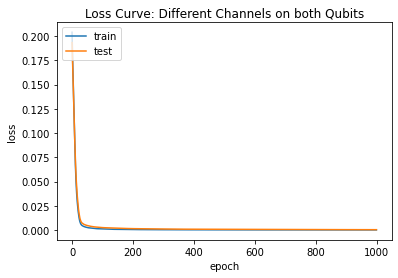

In [108]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 2.1718e-04 - 160ms/epoch - 23ms/step


In [110]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_diff_mse = tf.math.reduce_mean(fid)
print(fid_diff_mse)

tf.Tensor((0.9946771+3.5470294e-12j), shape=(), dtype=complex64)


### <font color='green'>Same Channel on both Qubits</font>

In [111]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [112]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [113]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [114]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [115]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [116]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [117]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 2s 62ms/step - loss: 0.1945 - val_loss: 0.1894
Epoch 2/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.1812 - val_loss: 0.1779
Epoch 3/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.1698 - val_loss: 0.1674
Epoch 4/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.1586 - val_loss: 0.1570
Epoch 5/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.1473 - val_loss: 0.1461
Epoch 6/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.1357 - val_loss: 0.1349
Epoch 7/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.1235 - val_loss: 0.1229
Epoch 8/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.1108 - val_loss: 0.1107
Epoch 9/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0981 - val_loss: 0.0984
Epoch 10/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0857 - val_loss: 0.0869
Epoch 11/

6/6 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 84/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 85/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 86/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 87/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 88/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 89/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 90/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 91/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 92/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 93/1000


6/6 [==============================] - 0s 14ms/step - loss: 5.9028e-04 - val_loss: 0.0015
Epoch 163/1000
6/6 [==============================] - 0s 16ms/step - loss: 5.8118e-04 - val_loss: 0.0016
Epoch 164/1000
6/6 [==============================] - 0s 16ms/step - loss: 5.6522e-04 - val_loss: 0.0015
Epoch 165/1000
6/6 [==============================] - 0s 15ms/step - loss: 5.5764e-04 - val_loss: 0.0015
Epoch 166/1000
6/6 [==============================] - 0s 14ms/step - loss: 5.5914e-04 - val_loss: 0.0015
Epoch 167/1000
6/6 [==============================] - 0s 13ms/step - loss: 5.5205e-04 - val_loss: 0.0015
Epoch 168/1000
6/6 [==============================] - 0s 15ms/step - loss: 5.5470e-04 - val_loss: 0.0015
Epoch 169/1000
6/6 [==============================] - 0s 17ms/step - loss: 5.4147e-04 - val_loss: 0.0015
Epoch 170/1000
6/6 [==============================] - 0s 20ms/step - loss: 5.4255e-04 - val_loss: 0.0015
Epoch 171/1000
6/6 [==============================] - 0s 20ms/step - l

6/6 [==============================] - 0s 15ms/step - loss: 3.5263e-04 - val_loss: 0.0011
Epoch 241/1000
6/6 [==============================] - 0s 17ms/step - loss: 3.4409e-04 - val_loss: 0.0011
Epoch 242/1000
6/6 [==============================] - 0s 16ms/step - loss: 3.4569e-04 - val_loss: 0.0011
Epoch 243/1000
6/6 [==============================] - 0s 17ms/step - loss: 3.4538e-04 - val_loss: 0.0011
Epoch 244/1000
6/6 [==============================] - 0s 16ms/step - loss: 3.3997e-04 - val_loss: 0.0011
Epoch 245/1000
6/6 [==============================] - 0s 15ms/step - loss: 3.3366e-04 - val_loss: 0.0011
Epoch 246/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.2608e-04 - val_loss: 0.0011
Epoch 247/1000
6/6 [==============================] - 0s 15ms/step - loss: 3.2905e-04 - val_loss: 0.0011
Epoch 248/1000
6/6 [==============================] - 0s 16ms/step - loss: 3.3931e-04 - val_loss: 0.0011
Epoch 249/1000
6/6 [==============================] - 0s 16ms/step - l

6/6 [==============================] - 0s 15ms/step - loss: 2.4671e-04 - val_loss: 8.8676e-04
Epoch 317/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.3872e-04 - val_loss: 8.9805e-04
Epoch 318/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.4216e-04 - val_loss: 8.7772e-04
Epoch 319/1000
6/6 [==============================] - 0s 16ms/step - loss: 2.3631e-04 - val_loss: 8.9687e-04
Epoch 320/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.3486e-04 - val_loss: 8.7586e-04
Epoch 321/1000
6/6 [==============================] - 0s 14ms/step - loss: 2.3237e-04 - val_loss: 8.6417e-04
Epoch 322/1000
6/6 [==============================] - 0s 17ms/step - loss: 2.2797e-04 - val_loss: 8.8058e-04
Epoch 323/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.3470e-04 - val_loss: 8.7464e-04
Epoch 324/1000
6/6 [==============================] - 0s 16ms/step - loss: 2.3690e-04 - val_loss: 8.7745e-04
Epoch 325/1000
6/6 [==============

6/6 [==============================] - 0s 14ms/step - loss: 1.8112e-04 - val_loss: 7.2619e-04
Epoch 392/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.8078e-04 - val_loss: 7.2486e-04
Epoch 393/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.7914e-04 - val_loss: 7.2454e-04
Epoch 394/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.8200e-04 - val_loss: 7.1818e-04
Epoch 395/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.8733e-04 - val_loss: 7.2880e-04
Epoch 396/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.8492e-04 - val_loss: 7.1481e-04
Epoch 397/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.8742e-04 - val_loss: 7.1214e-04
Epoch 398/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.8741e-04 - val_loss: 7.1924e-04
Epoch 399/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.8306e-04 - val_loss: 7.2483e-04
Epoch 400/1000
6/6 [==============

6/6 [==============================] - 0s 16ms/step - loss: 1.3580e-04 - val_loss: 5.9856e-04
Epoch 467/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.3347e-04 - val_loss: 6.0414e-04
Epoch 468/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.3062e-04 - val_loss: 5.9960e-04
Epoch 469/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.2904e-04 - val_loss: 5.9292e-04
Epoch 470/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.2881e-04 - val_loss: 5.9453e-04
Epoch 471/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.2846e-04 - val_loss: 5.9982e-04
Epoch 472/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.2711e-04 - val_loss: 6.0685e-04
Epoch 473/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.3028e-04 - val_loss: 5.9511e-04
Epoch 474/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.2775e-04 - val_loss: 5.8946e-04
Epoch 475/1000
6/6 [==============

6/6 [==============================] - 0s 15ms/step - loss: 1.0449e-04 - val_loss: 5.0375e-04
Epoch 542/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.0279e-04 - val_loss: 5.1594e-04
Epoch 543/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.0988e-04 - val_loss: 5.0367e-04
Epoch 544/1000
6/6 [==============================] - 0s 17ms/step - loss: 1.0229e-04 - val_loss: 5.0048e-04
Epoch 545/1000
6/6 [==============================] - 0s 17ms/step - loss: 1.0017e-04 - val_loss: 4.9957e-04
Epoch 546/1000
6/6 [==============================] - 0s 16ms/step - loss: 1.0422e-04 - val_loss: 4.9621e-04
Epoch 547/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.0782e-04 - val_loss: 5.0536e-04
Epoch 548/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.0202e-04 - val_loss: 5.0414e-04
Epoch 549/1000
6/6 [==============================] - 0s 16ms/step - loss: 9.7755e-05 - val_loss: 4.8489e-04
Epoch 550/1000
6/6 [==============

6/6 [==============================] - 0s 15ms/step - loss: 7.7469e-05 - val_loss: 4.1198e-04
Epoch 617/1000
6/6 [==============================] - 0s 14ms/step - loss: 7.5711e-05 - val_loss: 4.2066e-04
Epoch 618/1000
6/6 [==============================] - 0s 14ms/step - loss: 8.0423e-05 - val_loss: 4.2609e-04
Epoch 619/1000
6/6 [==============================] - 0s 14ms/step - loss: 7.9115e-05 - val_loss: 4.1491e-04
Epoch 620/1000
6/6 [==============================] - 0s 15ms/step - loss: 7.1986e-05 - val_loss: 4.0869e-04
Epoch 621/1000
6/6 [==============================] - 0s 14ms/step - loss: 6.9514e-05 - val_loss: 4.1236e-04
Epoch 622/1000
6/6 [==============================] - 0s 14ms/step - loss: 7.1585e-05 - val_loss: 4.1011e-04
Epoch 623/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.3522e-05 - val_loss: 4.1327e-04
Epoch 624/1000
6/6 [==============================] - 0s 15ms/step - loss: 7.3792e-05 - val_loss: 4.1199e-04
Epoch 625/1000
6/6 [==============

6/6 [==============================] - 0s 15ms/step - loss: 5.8713e-05 - val_loss: 3.5506e-04
Epoch 692/1000
6/6 [==============================] - 0s 15ms/step - loss: 5.8921e-05 - val_loss: 3.5944e-04
Epoch 693/1000
6/6 [==============================] - 0s 14ms/step - loss: 6.0732e-05 - val_loss: 3.5677e-04
Epoch 694/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.3125e-05 - val_loss: 3.4850e-04
Epoch 695/1000
6/6 [==============================] - 0s 15ms/step - loss: 6.2596e-05 - val_loss: 3.4848e-04
Epoch 696/1000
6/6 [==============================] - 0s 15ms/step - loss: 6.1109e-05 - val_loss: 3.5812e-04
Epoch 697/1000
6/6 [==============================] - 0s 16ms/step - loss: 6.0037e-05 - val_loss: 3.5285e-04
Epoch 698/1000
6/6 [==============================] - 0s 15ms/step - loss: 5.7842e-05 - val_loss: 3.4697e-04
Epoch 699/1000
6/6 [==============================] - 0s 14ms/step - loss: 5.4388e-05 - val_loss: 3.4682e-04
Epoch 700/1000
6/6 [==============

6/6 [==============================] - 0s 22ms/step - loss: 4.6167e-05 - val_loss: 2.9880e-04
Epoch 767/1000
6/6 [==============================] - 0s 26ms/step - loss: 4.3641e-05 - val_loss: 2.9285e-04
Epoch 768/1000
6/6 [==============================] - 0s 25ms/step - loss: 4.2662e-05 - val_loss: 2.9866e-04
Epoch 769/1000
6/6 [==============================] - 0s 21ms/step - loss: 4.5517e-05 - val_loss: 2.9735e-04
Epoch 770/1000
6/6 [==============================] - 0s 19ms/step - loss: 4.9496e-05 - val_loss: 2.9943e-04
Epoch 771/1000
6/6 [==============================] - 0s 18ms/step - loss: 4.8532e-05 - val_loss: 3.0431e-04
Epoch 772/1000
6/6 [==============================] - 0s 16ms/step - loss: 4.6470e-05 - val_loss: 2.9995e-04
Epoch 773/1000
6/6 [==============================] - 0s 14ms/step - loss: 4.5281e-05 - val_loss: 2.9091e-04
Epoch 774/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.3573e-05 - val_loss: 3.0001e-04
Epoch 775/1000
6/6 [==============

6/6 [==============================] - 0s 14ms/step - loss: 3.2659e-05 - val_loss: 2.5036e-04
Epoch 842/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.2681e-05 - val_loss: 2.5029e-04
Epoch 843/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.4590e-05 - val_loss: 2.6002e-04
Epoch 844/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.8092e-05 - val_loss: 2.5516e-04
Epoch 845/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.6468e-05 - val_loss: 2.6263e-04
Epoch 846/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.7976e-05 - val_loss: 2.5497e-04
Epoch 847/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.3794e-05 - val_loss: 2.5160e-04
Epoch 848/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.3885e-05 - val_loss: 2.4925e-04
Epoch 849/1000
6/6 [==============================] - 0s 14ms/step - loss: 3.0946e-05 - val_loss: 2.4942e-04
Epoch 850/1000
6/6 [==============

6/6 [==============================] - 0s 15ms/step - loss: 3.2539e-05 - val_loss: 2.3332e-04
Epoch 917/1000
6/6 [==============================] - 0s 16ms/step - loss: 3.0310e-05 - val_loss: 2.3469e-04
Epoch 918/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.9074e-05 - val_loss: 2.2881e-04
Epoch 919/1000
6/6 [==============================] - 0s 17ms/step - loss: 2.8193e-05 - val_loss: 2.2502e-04
Epoch 920/1000
6/6 [==============================] - 0s 19ms/step - loss: 2.7231e-05 - val_loss: 2.2628e-04
Epoch 921/1000
6/6 [==============================] - 0s 16ms/step - loss: 2.8312e-05 - val_loss: 2.2864e-04
Epoch 922/1000
6/6 [==============================] - 0s 17ms/step - loss: 2.8251e-05 - val_loss: 2.2503e-04
Epoch 923/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.6896e-05 - val_loss: 2.2129e-04
Epoch 924/1000
6/6 [==============================] - 0s 16ms/step - loss: 2.7075e-05 - val_loss: 2.2467e-04
Epoch 925/1000
6/6 [==============

6/6 [==============================] - 0s 14ms/step - loss: 2.5080e-05 - val_loss: 2.1410e-04
Epoch 992/1000
6/6 [==============================] - 0s 14ms/step - loss: 2.2830e-05 - val_loss: 2.0478e-04
Epoch 993/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.3542e-05 - val_loss: 2.0661e-04
Epoch 994/1000
6/6 [==============================] - 0s 14ms/step - loss: 2.2404e-05 - val_loss: 2.0914e-04
Epoch 995/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.2746e-05 - val_loss: 2.1119e-04
Epoch 996/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.2505e-05 - val_loss: 2.0555e-04
Epoch 997/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.1499e-05 - val_loss: 2.0415e-04
Epoch 998/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.0423e-05 - val_loss: 2.0484e-04
Epoch 999/1000
6/6 [==============================] - 0s 14ms/step - loss: 2.0061e-05 - val_loss: 1.9829e-04
Epoch 1000/1000
6/6 [=============

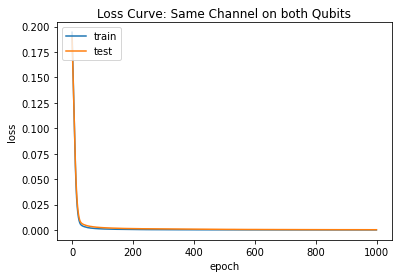

In [118]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 2.1434e-04 - 207ms/epoch - 30ms/step


In [120]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_mse = tf.math.reduce_mean(fid)
print(fid_same_mse)

tf.Tensor((0.99309874+3.9290173e-12j), shape=(), dtype=complex64)


### <font color='green'>One Channel on One Qubit</font>

In [121]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [122]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [123]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [124]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [125]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [126]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [127]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 1s 46ms/step - loss: 0.2051 - val_loss: 0.1946
Epoch 2/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.1863 - val_loss: 0.1795
Epoch 3/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1710 - val_loss: 0.1662
Epoch 4/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1567 - val_loss: 0.1529
Epoch 5/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1428 - val_loss: 0.1395
Epoch 6/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1288 - val_loss: 0.1257
Epoch 7/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1146 - val_loss: 0.1122
Epoch 8/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1008 - val_loss: 0.0990
Epoch 9/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0874 - val_loss: 0.0863
Epoch 10/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0749 - val_loss: 0.0746
Epoch 11/

6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 84/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 85/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 86/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 87/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 88/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 89/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 90/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 91/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 92/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 93/1000


Epoch 163/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.4169e-04 - val_loss: 0.0024
Epoch 164/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.3541e-04 - val_loss: 0.0023
Epoch 165/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.2320e-04 - val_loss: 0.0024
Epoch 166/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.2752e-04 - val_loss: 0.0023
Epoch 167/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.3550e-04 - val_loss: 0.0023
Epoch 168/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.1470e-04 - val_loss: 0.0023
Epoch 169/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.1416e-04 - val_loss: 0.0023
Epoch 170/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.1667e-04 - val_loss: 0.0023
Epoch 171/1000
6/6 [==============================] - 0s 14ms/step - loss: 7.0228e-04 - val_loss: 0.0023
Epoch 172/1000
6/6 [==============================] - 0

6/6 [==============================] - 0s 15ms/step - loss: 4.9920e-04 - val_loss: 0.0020
Epoch 242/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.9249e-04 - val_loss: 0.0020
Epoch 243/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.8727e-04 - val_loss: 0.0020
Epoch 244/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.8558e-04 - val_loss: 0.0020
Epoch 245/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.8712e-04 - val_loss: 0.0019
Epoch 246/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.8510e-04 - val_loss: 0.0020
Epoch 247/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.8668e-04 - val_loss: 0.0020
Epoch 248/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.7300e-04 - val_loss: 0.0019
Epoch 249/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.7686e-04 - val_loss: 0.0019
Epoch 250/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 13ms/step - loss: 3.8182e-04 - val_loss: 0.0018
Epoch 320/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.7883e-04 - val_loss: 0.0017
Epoch 321/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.6432e-04 - val_loss: 0.0018
Epoch 322/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.5866e-04 - val_loss: 0.0017
Epoch 323/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.5709e-04 - val_loss: 0.0017
Epoch 324/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6111e-04 - val_loss: 0.0017
Epoch 325/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.5965e-04 - val_loss: 0.0017
Epoch 326/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6362e-04 - val_loss: 0.0017
Epoch 327/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6526e-04 - val_loss: 0.0017
Epoch 328/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 13ms/step - loss: 2.9829e-04 - val_loss: 0.0016
Epoch 398/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.9469e-04 - val_loss: 0.0016
Epoch 399/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.9700e-04 - val_loss: 0.0016
Epoch 400/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.8777e-04 - val_loss: 0.0016
Epoch 401/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.8521e-04 - val_loss: 0.0016
Epoch 402/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.8435e-04 - val_loss: 0.0016
Epoch 403/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.8274e-04 - val_loss: 0.0016
Epoch 404/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.8478e-04 - val_loss: 0.0016
Epoch 405/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.9153e-04 - val_loss: 0.0016
Epoch 406/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 2.4001e-04 - val_loss: 0.0015
Epoch 476/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4314e-04 - val_loss: 0.0015
Epoch 477/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.4389e-04 - val_loss: 0.0015
Epoch 478/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4669e-04 - val_loss: 0.0015
Epoch 479/1000
6/6 [==============================] - 0s 14ms/step - loss: 2.4590e-04 - val_loss: 0.0015
Epoch 480/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.4162e-04 - val_loss: 0.0015
Epoch 481/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4138e-04 - val_loss: 0.0015
Epoch 482/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.3995e-04 - val_loss: 0.0015
Epoch 483/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.3713e-04 - val_loss: 0.0015
Epoch 484/1000
6/6 [==============================] - 0s 13ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 2.0444e-04 - val_loss: 0.0014
Epoch 554/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.0547e-04 - val_loss: 0.0014
Epoch 555/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.1154e-04 - val_loss: 0.0014
Epoch 556/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.0132e-04 - val_loss: 0.0014
Epoch 557/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.9587e-04 - val_loss: 0.0014
Epoch 558/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.9532e-04 - val_loss: 0.0014
Epoch 559/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.9631e-04 - val_loss: 0.0014
Epoch 560/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.9655e-04 - val_loss: 0.0014
Epoch 561/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.9396e-04 - val_loss: 0.0014
Epoch 562/1000
6/6 [==============================] - 0s 13ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 1.7668e-04 - val_loss: 0.0014
Epoch 632/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.6941e-04 - val_loss: 0.0014
Epoch 633/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.7289e-04 - val_loss: 0.0014
Epoch 634/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.7726e-04 - val_loss: 0.0014
Epoch 635/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.8177e-04 - val_loss: 0.0014
Epoch 636/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7789e-04 - val_loss: 0.0014
Epoch 637/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7176e-04 - val_loss: 0.0014
Epoch 638/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7052e-04 - val_loss: 0.0014
Epoch 639/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7475e-04 - val_loss: 0.0014
Epoch 640/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 1.4645e-04 - val_loss: 0.0013
Epoch 710/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.4883e-04 - val_loss: 0.0013
Epoch 711/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.5318e-04 - val_loss: 0.0013
Epoch 712/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.5240e-04 - val_loss: 0.0013
Epoch 713/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.4997e-04 - val_loss: 0.0013
Epoch 714/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.4845e-04 - val_loss: 0.0013
Epoch 715/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.4955e-04 - val_loss: 0.0013
Epoch 716/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.5381e-04 - val_loss: 0.0013
Epoch 717/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.5137e-04 - val_loss: 0.0013
Epoch 718/1000
6/6 [==============================] - 0s 13ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 1.4521e-04 - val_loss: 0.0013
Epoch 788/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.4543e-04 - val_loss: 0.0013
Epoch 789/1000
6/6 [==============================] - 0s 11ms/step - loss: 1.3899e-04 - val_loss: 0.0013
Epoch 790/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.3633e-04 - val_loss: 0.0013
Epoch 791/1000
6/6 [==============================] - 0s 15ms/step - loss: 1.3841e-04 - val_loss: 0.0013
Epoch 792/1000
6/6 [==============================] - 0s 17ms/step - loss: 1.3623e-04 - val_loss: 0.0013
Epoch 793/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.3061e-04 - val_loss: 0.0013
Epoch 794/1000
6/6 [==============================] - 0s 14ms/step - loss: 1.3415e-04 - val_loss: 0.0013
Epoch 795/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.3760e-04 - val_loss: 0.0013
Epoch 796/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 14ms/step - loss: 1.2534e-04 - val_loss: 0.0012
Epoch 866/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2659e-04 - val_loss: 0.0012
Epoch 867/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.3210e-04 - val_loss: 0.0012
Epoch 868/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.3115e-04 - val_loss: 0.0012
Epoch 869/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.2632e-04 - val_loss: 0.0012
Epoch 870/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2577e-04 - val_loss: 0.0012
Epoch 871/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2158e-04 - val_loss: 0.0012
Epoch 872/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.2248e-04 - val_loss: 0.0012
Epoch 873/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1906e-04 - val_loss: 0.0012
Epoch 874/1000
6/6 [==============================] - 0s 13ms/step - l

6/6 [==============================] - 0s 13ms/step - loss: 1.1026e-04 - val_loss: 0.0012
Epoch 944/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.1626e-04 - val_loss: 0.0012
Epoch 945/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1476e-04 - val_loss: 0.0012
Epoch 946/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.1807e-04 - val_loss: 0.0012
Epoch 947/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1408e-04 - val_loss: 0.0012
Epoch 948/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.1259e-04 - val_loss: 0.0012
Epoch 949/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1802e-04 - val_loss: 0.0012
Epoch 950/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1081e-04 - val_loss: 0.0012
Epoch 951/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.0736e-04 - val_loss: 0.0012
Epoch 952/1000
6/6 [==============================] - 0s 13ms/step - l

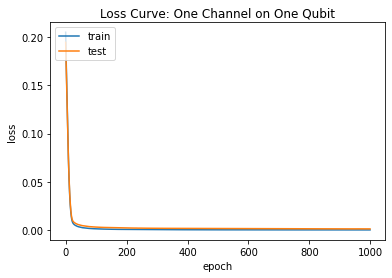

In [128]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: One Channel on One Qubit')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [129]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0013 - 158ms/epoch - 23ms/step


In [130]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_mse = tf.math.reduce_mean(fid)
print(fid_one_mse)

tf.Tensor((0.99398863+6.984919e-12j), shape=(), dtype=complex64)


## <font color='red'>Training the Algorithm (INF)</font>

### <font color='red'>Different Channels on both Qubits</font>

In [131]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [132]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [133]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [134]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [135]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [136]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [137]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 2s 84ms/step - loss: 0.7079 - val_loss: 0.6230
Epoch 2/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.5859 - val_loss: 0.5250
Epoch 3/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.4719 - val_loss: 0.4290
Epoch 4/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.3682 - val_loss: 0.3425
Epoch 5/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.2848 - val_loss: 0.2753
Epoch 6/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.2285 - val_loss: 0.2301
Epoch 7/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.1901 - val_loss: 0.1959
Epoch 8/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.1578 - val_loss: 0.1705
Epoch 9/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.1331 - val_loss: 0.1507
Epoch 10/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.1136 - val_loss: 0.1320
Epoch 11/

6/6 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0135
Epoch 84/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0133
Epoch 85/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.0048 - val_loss: 0.0132
Epoch 86/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0131
Epoch 87/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0130
Epoch 88/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0129
Epoch 89/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 90/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0126
Epoch 91/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0126
Epoch 92/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.0124
Epoch 93/1000


6/6 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 165/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0086
Epoch 166/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 167/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0084
Epoch 168/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 169/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 170/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 171/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 172/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 173/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0083
Epoch

6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0073
Epoch 246/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 247/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 248/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0073
Epoch 249/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 250/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 251/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 252/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 253/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 254/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0071
Epoch

6/6 [==============================] - 0s 13ms/step - loss: 8.7613e-04 - val_loss: 0.0066
Epoch 325/1000
6/6 [==============================] - 0s 11ms/step - loss: 8.7317e-04 - val_loss: 0.0066
Epoch 326/1000
6/6 [==============================] - 0s 12ms/step - loss: 8.6060e-04 - val_loss: 0.0065
Epoch 327/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.3809e-04 - val_loss: 0.0066
Epoch 328/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.3180e-04 - val_loss: 0.0065
Epoch 329/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.1977e-04 - val_loss: 0.0066
Epoch 330/1000
6/6 [==============================] - 0s 12ms/step - loss: 8.3115e-04 - val_loss: 0.0065
Epoch 331/1000
6/6 [==============================] - 0s 12ms/step - loss: 8.0794e-04 - val_loss: 0.0065
Epoch 332/1000
6/6 [==============================] - 0s 13ms/step - loss: 8.1758e-04 - val_loss: 0.0065
Epoch 333/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 13ms/step - loss: 6.4659e-04 - val_loss: 0.0061
Epoch 403/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.4146e-04 - val_loss: 0.0061
Epoch 404/1000
6/6 [==============================] - 0s 12ms/step - loss: 6.2470e-04 - val_loss: 0.0060
Epoch 405/1000
6/6 [==============================] - 0s 12ms/step - loss: 6.2849e-04 - val_loss: 0.0061
Epoch 406/1000
6/6 [==============================] - 0s 11ms/step - loss: 6.3045e-04 - val_loss: 0.0061
Epoch 407/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.2029e-04 - val_loss: 0.0060
Epoch 408/1000
6/6 [==============================] - 0s 12ms/step - loss: 6.1976e-04 - val_loss: 0.0060
Epoch 409/1000
6/6 [==============================] - 0s 12ms/step - loss: 6.2330e-04 - val_loss: 0.0061
Epoch 410/1000
6/6 [==============================] - 0s 13ms/step - loss: 6.3716e-04 - val_loss: 0.0060
Epoch 411/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 5.0876e-04 - val_loss: 0.0058
Epoch 481/1000
6/6 [==============================] - 0s 13ms/step - loss: 5.0220e-04 - val_loss: 0.0058
Epoch 482/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.1706e-04 - val_loss: 0.0058
Epoch 483/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.1343e-04 - val_loss: 0.0058
Epoch 484/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.1486e-04 - val_loss: 0.0058
Epoch 485/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.2139e-04 - val_loss: 0.0058
Epoch 486/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.1382e-04 - val_loss: 0.0058
Epoch 487/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.9419e-04 - val_loss: 0.0058
Epoch 488/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.0350e-04 - val_loss: 0.0058
Epoch 489/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 4.2973e-04 - val_loss: 0.0057
Epoch 559/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.3028e-04 - val_loss: 0.0056
Epoch 560/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.2015e-04 - val_loss: 0.0056
Epoch 561/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.1570e-04 - val_loss: 0.0057
Epoch 562/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.2601e-04 - val_loss: 0.0056
Epoch 563/1000
6/6 [==============================] - 0s 13ms/step - loss: 4.3746e-04 - val_loss: 0.0057
Epoch 564/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.3612e-04 - val_loss: 0.0057
Epoch 565/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.1827e-04 - val_loss: 0.0056
Epoch 566/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.1432e-04 - val_loss: 0.0056
Epoch 567/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 3.4618e-04 - val_loss: 0.0055
Epoch 637/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.3226e-04 - val_loss: 0.0055
Epoch 638/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.3954e-04 - val_loss: 0.0055
Epoch 639/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.5169e-04 - val_loss: 0.0056
Epoch 640/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.4952e-04 - val_loss: 0.0056
Epoch 641/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6340e-04 - val_loss: 0.0055
Epoch 642/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.7112e-04 - val_loss: 0.0055
Epoch 643/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6482e-04 - val_loss: 0.0055
Epoch 644/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.5907e-04 - val_loss: 0.0056
Epoch 645/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 3.1437e-04 - val_loss: 0.0055
Epoch 715/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.1306e-04 - val_loss: 0.0055
Epoch 716/1000
6/6 [==============================] - 0s 13ms/step - loss: 3.0746e-04 - val_loss: 0.0055
Epoch 717/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.9374e-04 - val_loss: 0.0055
Epoch 718/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.9895e-04 - val_loss: 0.0055
Epoch 719/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.9725e-04 - val_loss: 0.0055
Epoch 720/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.8991e-04 - val_loss: 0.0055
Epoch 721/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.9986e-04 - val_loss: 0.0055
Epoch 722/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.0967e-04 - val_loss: 0.0055
Epoch 723/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 13ms/step - loss: 2.5462e-04 - val_loss: 0.0054
Epoch 793/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.6774e-04 - val_loss: 0.0054
Epoch 794/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.6153e-04 - val_loss: 0.0054
Epoch 795/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5432e-04 - val_loss: 0.0055
Epoch 796/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5963e-04 - val_loss: 0.0054
Epoch 797/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5576e-04 - val_loss: 0.0054
Epoch 798/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4813e-04 - val_loss: 0.0054
Epoch 799/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5619e-04 - val_loss: 0.0054
Epoch 800/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.5456e-04 - val_loss: 0.0054
Epoch 801/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 2.4979e-04 - val_loss: 0.0054
Epoch 871/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5016e-04 - val_loss: 0.0054
Epoch 872/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.5677e-04 - val_loss: 0.0054
Epoch 873/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.5644e-04 - val_loss: 0.0054
Epoch 874/1000
6/6 [==============================] - 0s 15ms/step - loss: 2.5222e-04 - val_loss: 0.0054
Epoch 875/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4086e-04 - val_loss: 0.0054
Epoch 876/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.3729e-04 - val_loss: 0.0054
Epoch 877/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.2877e-04 - val_loss: 0.0054
Epoch 878/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.3353e-04 - val_loss: 0.0054
Epoch 879/1000
6/6 [==============================] - 0s 13ms/step - l

6/6 [==============================] - 0s 13ms/step - loss: 2.0109e-04 - val_loss: 0.0053
Epoch 949/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.0083e-04 - val_loss: 0.0053
Epoch 950/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.0702e-04 - val_loss: 0.0054
Epoch 951/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.0485e-04 - val_loss: 0.0053
Epoch 952/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.0191e-04 - val_loss: 0.0053
Epoch 953/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.0185e-04 - val_loss: 0.0053
Epoch 954/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.9592e-04 - val_loss: 0.0053
Epoch 955/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.0269e-04 - val_loss: 0.0053
Epoch 956/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.0037e-04 - val_loss: 0.0053
Epoch 957/1000
6/6 [==============================] - 0s 13ms/step - l

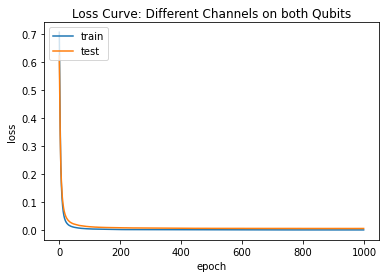

In [138]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [139]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0048 - 203ms/epoch - 29ms/step


In [140]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_both_inf = tf.math.reduce_mean(fid)
print(fid_both_inf)

tf.Tensor((0.99516547+2.386514e-11j), shape=(), dtype=complex64)


### <font color='red'>Same Channel on both Qubits</font>

In [141]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [142]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [143]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [144]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [145]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [146]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [147]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 1s 42ms/step - loss: 0.7538 - val_loss: 0.7142
Epoch 2/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.6405 - val_loss: 0.6147
Epoch 3/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.5278 - val_loss: 0.5124
Epoch 4/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.4276 - val_loss: 0.4168
Epoch 5/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.3387 - val_loss: 0.3331
Epoch 6/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.2715 - val_loss: 0.2722
Epoch 7/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.2233 - val_loss: 0.2289
Epoch 8/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1843 - val_loss: 0.1954
Epoch 9/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.1546 - val_loss: 0.1707
Epoch 10/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1328 - val_loss: 0.1495
Epoch 11/

6/6 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0149
Epoch 84/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0054 - val_loss: 0.0148
Epoch 85/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0054 - val_loss: 0.0147
Epoch 86/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0053 - val_loss: 0.0145
Epoch 87/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0144
Epoch 88/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0143
Epoch 89/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0142
Epoch 90/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0050 - val_loss: 0.0141
Epoch 91/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 0.0140
Epoch 92/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0048 - val_loss: 0.0139
Epoch 93/1000


6/6 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0095
Epoch 165/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0095
Epoch 166/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 167/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 168/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0094
Epoch 169/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 170/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 171/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 172/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0093
Epoch 173/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch

6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 246/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0079
Epoch 247/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 248/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 249/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 250/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 251/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 252/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 253/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 254/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch

Epoch 326/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.3210e-04 - val_loss: 0.0071
Epoch 327/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.3670e-04 - val_loss: 0.0071
Epoch 328/1000
6/6 [==============================] - 0s 12ms/step - loss: 9.2814e-04 - val_loss: 0.0071
Epoch 329/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.2259e-04 - val_loss: 0.0071
Epoch 330/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.2811e-04 - val_loss: 0.0071
Epoch 331/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.2297e-04 - val_loss: 0.0071
Epoch 332/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.4018e-04 - val_loss: 0.0071
Epoch 333/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.1887e-04 - val_loss: 0.0071
Epoch 334/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.1162e-04 - val_loss: 0.0071
Epoch 335/1000
6/6 [==============================] - 0

6/6 [==============================] - 0s 10ms/step - loss: 7.1544e-04 - val_loss: 0.0068
Epoch 405/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.1994e-04 - val_loss: 0.0068
Epoch 406/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.1948e-04 - val_loss: 0.0067
Epoch 407/1000
6/6 [==============================] - 0s 11ms/step - loss: 7.2621e-04 - val_loss: 0.0068
Epoch 408/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.3159e-04 - val_loss: 0.0068
Epoch 409/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.1506e-04 - val_loss: 0.0068
Epoch 410/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.1725e-04 - val_loss: 0.0068
Epoch 411/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.0353e-04 - val_loss: 0.0068
Epoch 412/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.1343e-04 - val_loss: 0.0067
Epoch 413/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 5.8007e-04 - val_loss: 0.0065
Epoch 483/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.7946e-04 - val_loss: 0.0065
Epoch 484/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.7493e-04 - val_loss: 0.0065
Epoch 485/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.7859e-04 - val_loss: 0.0065
Epoch 486/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.8526e-04 - val_loss: 0.0065
Epoch 487/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.7620e-04 - val_loss: 0.0065
Epoch 488/1000
6/6 [==============================] - 0s 10ms/step - loss: 5.6256e-04 - val_loss: 0.0065
Epoch 489/1000
6/6 [==============================] - 0s 10ms/step - loss: 5.7308e-04 - val_loss: 0.0065
Epoch 490/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.7576e-04 - val_loss: 0.0066
Epoch 491/1000
6/6 [==============================] - 0s 11ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 4.7189e-04 - val_loss: 0.0063
Epoch 561/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.6854e-04 - val_loss: 0.0063
Epoch 562/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.8653e-04 - val_loss: 0.0064
Epoch 563/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.7177e-04 - val_loss: 0.0064
Epoch 564/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.7400e-04 - val_loss: 0.0063
Epoch 565/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.8182e-04 - val_loss: 0.0064
Epoch 566/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.7837e-04 - val_loss: 0.0063
Epoch 567/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.6402e-04 - val_loss: 0.0063
Epoch 568/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.7143e-04 - val_loss: 0.0063
Epoch 569/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 10ms/step - loss: 4.0191e-04 - val_loss: 0.0062
Epoch 639/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.0216e-04 - val_loss: 0.0062
Epoch 640/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.9299e-04 - val_loss: 0.0062
Epoch 641/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.9007e-04 - val_loss: 0.0062
Epoch 642/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.8525e-04 - val_loss: 0.0062
Epoch 643/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.0605e-04 - val_loss: 0.0062
Epoch 644/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.9969e-04 - val_loss: 0.0062
Epoch 645/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.9932e-04 - val_loss: 0.0062
Epoch 646/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.8663e-04 - val_loss: 0.0062
Epoch 647/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 3.4599e-04 - val_loss: 0.0061
Epoch 717/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.4358e-04 - val_loss: 0.0061
Epoch 718/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.3151e-04 - val_loss: 0.0061
Epoch 719/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.3599e-04 - val_loss: 0.0061
Epoch 720/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.3496e-04 - val_loss: 0.0061
Epoch 721/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.3179e-04 - val_loss: 0.0061
Epoch 722/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.2629e-04 - val_loss: 0.0061
Epoch 723/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.2590e-04 - val_loss: 0.0061
Epoch 724/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.3276e-04 - val_loss: 0.0061
Epoch 725/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 3.0360e-04 - val_loss: 0.0061
Epoch 795/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.8732e-04 - val_loss: 0.0061
Epoch 796/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.9459e-04 - val_loss: 0.0061
Epoch 797/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.0012e-04 - val_loss: 0.0061
Epoch 798/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.0301e-04 - val_loss: 0.0061
Epoch 799/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.0783e-04 - val_loss: 0.0061
Epoch 800/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.0223e-04 - val_loss: 0.0061
Epoch 801/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.0122e-04 - val_loss: 0.0061
Epoch 802/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.0100e-04 - val_loss: 0.0061
Epoch 803/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 10ms/step - loss: 2.4967e-04 - val_loss: 0.0060
Epoch 873/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.5048e-04 - val_loss: 0.0060
Epoch 874/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.5333e-04 - val_loss: 0.0060
Epoch 875/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.4527e-04 - val_loss: 0.0060
Epoch 876/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.4678e-04 - val_loss: 0.0060
Epoch 877/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.4232e-04 - val_loss: 0.0060
Epoch 878/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.4522e-04 - val_loss: 0.0060
Epoch 879/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.4279e-04 - val_loss: 0.0060
Epoch 880/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.6330e-04 - val_loss: 0.0061
Epoch 881/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 10ms/step - loss: 2.2335e-04 - val_loss: 0.0060
Epoch 951/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2847e-04 - val_loss: 0.0060
Epoch 952/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.3195e-04 - val_loss: 0.0060
Epoch 953/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2691e-04 - val_loss: 0.0059
Epoch 954/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.2715e-04 - val_loss: 0.0060
Epoch 955/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.3117e-04 - val_loss: 0.0060
Epoch 956/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2007e-04 - val_loss: 0.0060
Epoch 957/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.1926e-04 - val_loss: 0.0060
Epoch 958/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.3557e-04 - val_loss: 0.0060
Epoch 959/1000
6/6 [==============================] - 0s 10ms/step - lo

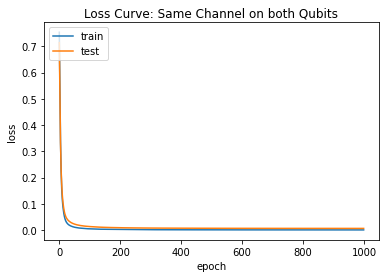

In [148]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [149]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0061 - 152ms/epoch - 22ms/step


In [150]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_inf = tf.math.reduce_mean(fid)
print(fid_same_inf)

tf.Tensor((0.99391586-2.561137e-11j), shape=(), dtype=complex64)


### <font color='red'>One Channel on one Qubit</font>

In [151]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [152]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [153]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [154]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[500:800]
y_val_list = vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [155]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [156]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [157]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 1s 37ms/step - loss: 0.7409 - val_loss: 0.6765
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.6388 - val_loss: 0.5887
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.5367 - val_loss: 0.4944
Epoch 4/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.4373 - val_loss: 0.4015
Epoch 5/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.3457 - val_loss: 0.3204
Epoch 6/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2732 - val_loss: 0.2553
Epoch 7/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.2196 - val_loss: 0.2107
Epoch 8/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1802 - val_loss: 0.1776
Epoch 9/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1479 - val_loss: 0.1518
Epoch 10/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1251 - val_loss: 0.1320
Epoch 11/

6/6 [==============================] - 0s 10ms/step - loss: 0.0051 - val_loss: 0.0126
Epoch 84/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0125
Epoch 85/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 86/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0049 - val_loss: 0.0123
Epoch 87/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 88/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 89/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 0.0120
Epoch 90/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0119
Epoch 91/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0045 - val_loss: 0.0118
Epoch 92/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0117
Epoch 93/1000


6/6 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0083
Epoch 165/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0083
Epoch 166/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 167/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0083
Epoch 168/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0082
Epoch 169/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0083
Epoch 170/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 171/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 172/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0081
Epoch 173/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0081
Epoch 

6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 246/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 247/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 248/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 249/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 250/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 251/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 252/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 253/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 254/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 2

Epoch 326/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.4968e-04 - val_loss: 0.0064
Epoch 327/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.5484e-04 - val_loss: 0.0065
Epoch 328/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.4852e-04 - val_loss: 0.0065
Epoch 329/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.5185e-04 - val_loss: 0.0064
Epoch 330/1000
6/6 [==============================] - 0s 11ms/step - loss: 9.4783e-04 - val_loss: 0.0065
Epoch 331/1000
6/6 [==============================] - 0s 11ms/step - loss: 9.5613e-04 - val_loss: 0.0065
Epoch 332/1000
6/6 [==============================] - 0s 11ms/step - loss: 9.4465e-04 - val_loss: 0.0065
Epoch 333/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.3662e-04 - val_loss: 0.0064
Epoch 334/1000
6/6 [==============================] - 0s 10ms/step - loss: 9.4979e-04 - val_loss: 0.0064
Epoch 335/1000
6/6 [==============================] - 0

6/6 [==============================] - 0s 11ms/step - loss: 7.2536e-04 - val_loss: 0.0061
Epoch 405/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.2528e-04 - val_loss: 0.0061
Epoch 406/1000
6/6 [==============================] - 0s 11ms/step - loss: 7.2138e-04 - val_loss: 0.0061
Epoch 407/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.2475e-04 - val_loss: 0.0061
Epoch 408/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.2313e-04 - val_loss: 0.0061
Epoch 409/1000
6/6 [==============================] - 0s 11ms/step - loss: 7.1519e-04 - val_loss: 0.0061
Epoch 410/1000
6/6 [==============================] - 0s 11ms/step - loss: 7.1802e-04 - val_loss: 0.0061
Epoch 411/1000
6/6 [==============================] - 0s 10ms/step - loss: 7.0917e-04 - val_loss: 0.0061
Epoch 412/1000
6/6 [==============================] - 0s 11ms/step - loss: 7.1642e-04 - val_loss: 0.0061
Epoch 413/1000
6/6 [==============================] - 0s 11ms/step - l

6/6 [==============================] - 0s 12ms/step - loss: 5.7855e-04 - val_loss: 0.0059
Epoch 483/1000
6/6 [==============================] - 0s 10ms/step - loss: 5.7877e-04 - val_loss: 0.0060
Epoch 484/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.9353e-04 - val_loss: 0.0059
Epoch 485/1000
6/6 [==============================] - 0s 10ms/step - loss: 5.8235e-04 - val_loss: 0.0059
Epoch 486/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.6895e-04 - val_loss: 0.0059
Epoch 487/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.6001e-04 - val_loss: 0.0059
Epoch 488/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.6544e-04 - val_loss: 0.0059
Epoch 489/1000
6/6 [==============================] - 0s 10ms/step - loss: 5.6579e-04 - val_loss: 0.0059
Epoch 490/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.6197e-04 - val_loss: 0.0059
Epoch 491/1000
6/6 [==============================] - 0s 11ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 4.6172e-04 - val_loss: 0.0057
Epoch 561/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.5892e-04 - val_loss: 0.0058
Epoch 562/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.5704e-04 - val_loss: 0.0058
Epoch 563/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.5127e-04 - val_loss: 0.0057
Epoch 564/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.5574e-04 - val_loss: 0.0057
Epoch 565/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.5633e-04 - val_loss: 0.0057
Epoch 566/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.7092e-04 - val_loss: 0.0057
Epoch 567/1000
6/6 [==============================] - 0s 10ms/step - loss: 4.5916e-04 - val_loss: 0.0057
Epoch 568/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.4097e-04 - val_loss: 0.0058
Epoch 569/1000
6/6 [==============================] - 0s 11ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 3.8903e-04 - val_loss: 0.0057
Epoch 639/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.6888e-04 - val_loss: 0.0057
Epoch 640/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6462e-04 - val_loss: 0.0057
Epoch 641/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.7250e-04 - val_loss: 0.0056
Epoch 642/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.7797e-04 - val_loss: 0.0056
Epoch 643/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.7349e-04 - val_loss: 0.0056
Epoch 644/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.7870e-04 - val_loss: 0.0056
Epoch 645/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.7521e-04 - val_loss: 0.0055
Epoch 646/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6302e-04 - val_loss: 0.0056
Epoch 647/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 10ms/step - loss: 3.2262e-04 - val_loss: 0.0056
Epoch 717/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.1250e-04 - val_loss: 0.0056
Epoch 718/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.2022e-04 - val_loss: 0.0056
Epoch 719/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.1807e-04 - val_loss: 0.0055
Epoch 720/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.2286e-04 - val_loss: 0.0055
Epoch 721/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.2034e-04 - val_loss: 0.0055
Epoch 722/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.2475e-04 - val_loss: 0.0056
Epoch 723/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.1160e-04 - val_loss: 0.0055
Epoch 724/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.0967e-04 - val_loss: 0.0055
Epoch 725/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 10ms/step - loss: 2.7702e-04 - val_loss: 0.0055
Epoch 795/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.6423e-04 - val_loss: 0.0055
Epoch 796/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.6814e-04 - val_loss: 0.0055
Epoch 797/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.7212e-04 - val_loss: 0.0055
Epoch 798/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.6981e-04 - val_loss: 0.0055
Epoch 799/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.7804e-04 - val_loss: 0.0055
Epoch 800/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.6952e-04 - val_loss: 0.0054
Epoch 801/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.6488e-04 - val_loss: 0.0054
Epoch 802/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.6135e-04 - val_loss: 0.0055
Epoch 803/1000
6/6 [==============================] - 0s 11ms/step - l

6/6 [==============================] - 0s 10ms/step - loss: 2.3447e-04 - val_loss: 0.0054
Epoch 873/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.3637e-04 - val_loss: 0.0054
Epoch 874/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.2633e-04 - val_loss: 0.0054
Epoch 875/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.3237e-04 - val_loss: 0.0055
Epoch 876/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2939e-04 - val_loss: 0.0055
Epoch 877/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2749e-04 - val_loss: 0.0054
Epoch 878/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.3250e-04 - val_loss: 0.0054
Epoch 879/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.5148e-04 - val_loss: 0.0055
Epoch 880/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.5174e-04 - val_loss: 0.0054
Epoch 881/1000
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 10ms/step - loss: 2.0678e-04 - val_loss: 0.0054
Epoch 951/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.0439e-04 - val_loss: 0.0054
Epoch 952/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.1128e-04 - val_loss: 0.0054
Epoch 953/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2354e-04 - val_loss: 0.0054
Epoch 954/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.3503e-04 - val_loss: 0.0054
Epoch 955/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.2688e-04 - val_loss: 0.0054
Epoch 956/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.2092e-04 - val_loss: 0.0054
Epoch 957/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.1182e-04 - val_loss: 0.0054
Epoch 958/1000
6/6 [==============================] - 0s 10ms/step - loss: 2.0991e-04 - val_loss: 0.0053
Epoch 959/1000
6/6 [==============================] - 0s 10ms/step - lo

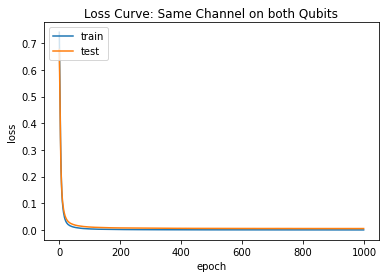

In [158]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [159]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0056 - 148ms/epoch - 21ms/step


In [160]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_inf = tf.math.reduce_mean(fid)
print(fid_one_inf)

tf.Tensor((0.9943794-8.0035535e-12j), shape=(), dtype=complex64)
